In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle
import numpy as np
import matplotlib.pyplot as plt
from fxpmath import Fxp
import copy

In [2]:
#method for unpacking the cifar Data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#method for quantizing a numpy array
def quantisation(inputArray, bitSize, fractBits = 0):
     #compute scale and zeroPoint
    maximum = np.max(inputArray);
    minimum = np.min(inputArray);
    valueRange = maximum - minimum;
    
    #using a fxpMath dummy to get the bounds for quantisation
    fxDummy = Fxp(1,signed = (minimum < 0), n_word = bitSize, n_frac = fractBits)
    maxFpVal = fxDummy.upper
    minFpVal = fxDummy.lower

    #scale = 1 when only one value is present to avoid division by 0
    scale = 1;
    if (valueRange != 0):
        scale = (maxFpVal - minFpVal) / valueRange;
    zeroPoint = minFpVal-(scale*minimum);
    
    #the actual quantisation and restructuring into a fxp-array
    output = Fxp((inputArray * scale) - zeroPoint, (minimum < 0), bitSize, fractBits)

    return output;

def fixedPointConversion(inputArray, bitSize, fractBits = 0):
    output = Fxp(inputArray, signed= True, n_word = bitSize, n_frac = fractBits)
    return (output)

In [3]:
#import the first cifar dataset
batch1 = unpickle("cifarData/data_batch_1")
trainingImagesLinear = batch1.get(list(batch1.keys())[2])
trainingLabels = np.array(batch1.get(list(batch1.keys())[1]))


#import validation dataset
validationData = unpickle("cifarData/test_batch")
testImagesLinear = validationData.get(list(validationData.keys())[2])
testLabels = np.array(validationData.get(list(validationData.keys())[1]))

#reshape each picture from 1000, 3072 to 1000, 32, 32, 3
for i in range(10000):
    #separating the channels and reshaping into the 32-pixel-format
    pxls_R = trainingImagesLinear[i][0:1024].reshape(32,32)
    pxls_G = trainingImagesLinear[i][1024:2048].reshape(32,32)
    pxls_B = trainingImagesLinear[i][2048:3072].reshape(32,32)
    #reassembling the array usind depth-first-stack
    img = np.dstack((pxls_R, pxls_G, pxls_B))
    if (i == 0):
        #initializing the array-variable
        trainingImages = np.reshape(img, (1,32,32,3))
    else:
        trainingImages = np.vstack((trainingImages, np.reshape(img, (1,32,32,3))))

#repeating for the validation data
for i in range(10000):
    pxls_R = testImagesLinear[i][0:1024].reshape(32,32)
    pxls_G = testImagesLinear[i][1024:2048].reshape(32,32)
    pxls_B = testImagesLinear[i][2048:3072].reshape(32,32)
    img = np.dstack((pxls_R, pxls_G, pxls_B))
    if (i == 0):
        testImages = np.reshape(img, (1,32,32,3))
    else:
        testImages = np.vstack((testImages, np.reshape(img, (1,32,32,3))))

#set to True to display some of the images for inspection
if (False):
    plt.figure(figsize=(10,10))
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(testImages[i])
        plt.xlabel(class_names[trainingLabels[i]])
    plt.show()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)             

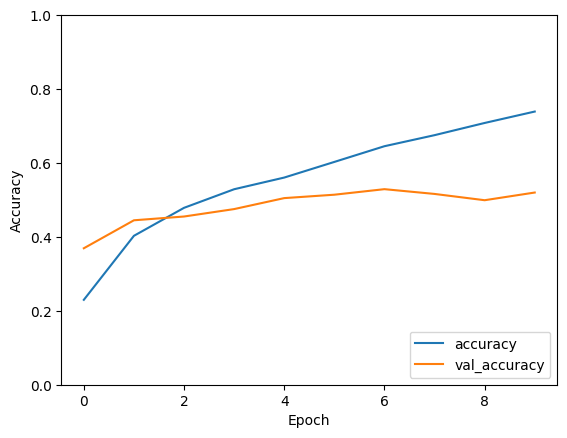

313/313 - 1s - loss: 1.6663 - accuracy: 0.5200 - 532ms/epoch - 2ms/step
0.5199999809265137


In [4]:
#convolution layers for feature extraction
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#fully connected layers for class prediction
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

#print the current model summary
model.summary()

#preparing model for training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#training the model
history = model.fit(trainingImages, trainingLabels, epochs=10, 
                    validation_data=(testImages, testLabels))

#set to True to display the changing accuracy of the model during training
if(True):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

#display the accuracy of the trained model
test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=2)
print(test_acc)

#get the weights of the model 
weights = model.get_weights()

Layer: 0 bits: 6 fractional Bits: 6 Accuracy: 
0.510699987411499
Layer: 2 bits: 6 fractional Bits: 6 Accuracy: 
0.5095000267028809
Layer: 4 bits: 6 fractional Bits: 6 Accuracy: 
0.5038999915122986
Layer: 6 bits: 6 fractional Bits: 6 Accuracy: 
0.5009999871253967
Layer: 7 bits: 4 fractional Bits: 4 Accuracy: 
0.48019999265670776


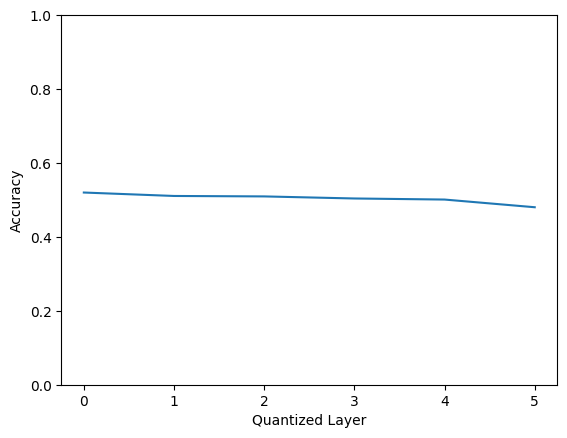

average storage use: 5.6 Bits


In [5]:
fractBitsList = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
maxBitSize = 24
tolerancePerLayer = 0.05
layerCount = len(model.layers)
averageStorageUse = []
accuracyDeveloptment = [test_acc]

#optimizes layer by layer
for currentLayer in range(layerCount):
    originalLayer = copy.deepcopy(model.layers[currentLayer])
    #only computes if layer has weights
    if (originalLayer.get_weights() != []):
        #initializes matrix for storing layer accuracy
        layerAccuracy =  np.zeros((maxBitSize, len(fractBitsList)))
        #iterates over specified numberfs of fractional bits, and specified number of overall bits for each
        for fractBitsIdx in range(len(fractBitsList)):
            for bits in range(max(fractBitsList[fractBitsIdx], 1), maxBitSize + 1):
                #initializes a new container for all weights of the current layer
                newLayer = []
                #iterates over all sets of weights in layer (needed, because the list of all weights has inhomogenus shape, so numpy cant handle it)
                for weightCount in range(len(originalLayer.get_weights())):
                    #append the quantized weights to new layer
                    newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer.get_weights()[weightCount]), bits, fractBitsList[fractBitsIdx]))
                #sets the new layer
                model.layers[currentLayer].set_weights(newLayer)
                #tests the new accuracy and stores it in a matrix
                test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=0)
                layerAccuracy[bits-1][fractBitsIdx] = test_acc        

        #detecting the best accuracy by tolerance
        #ToDo: optimize the function picking the best sizes
        bestAccuracy = {"bitIdx" : 0, "fractIdx" : 0, "accuracy" : 0}
        for bits in range(maxBitSize):
            for fractBits in range(len(fractBitsList)):
                if ((layerAccuracy[bits][fractBits] - tolerancePerLayer) > bestAccuracy["accuracy"]):
                    bestAccuracy["bitIdx"] = bits
                    bestAccuracy["fractIdx"] = fractBits
                    bestAccuracy["accuracy"] = layerAccuracy[bits][fractBits]
        
        #set the final new weights
        if (bestAccuracy["bitIdx"] > 0):
            newLayer = []
            for weightCount in range(len(originalLayer.get_weights())):
                newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer.get_weights()[weightCount]), bestAccuracy["bitIdx"] + 1, fractBitsList[bestAccuracy["fractIdx"]]))
            model.layers[currentLayer].set_weights(newLayer)
        print("Layer: " + str(currentLayer) + " bits: " + str(bestAccuracy["bitIdx"] + 1) + " fractional Bits: " + str(fractBitsList[bestAccuracy["fractIdx"]]) + " Accuracy: ")
        averageStorageUse.append(bestAccuracy["bitIdx"] + 1)
        test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=0)
        print (test_acc)
        accuracyDeveloptment.append(test_acc)

plt.xlabel("Quantized Layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.plot(accuracyDeveloptment)
plt.show()

print("average storage use: " + str(np.mean(averageStorageUse)) + " Bits")

In [6]:
%%script False
#this version of quantization will be worked on later, since quantization has to be optimized for biases

#quantizing the weights with differently sized integers and FP-ranges, then storing them
accuracys = {}  
#iterating over different amounts of fractional bits
fractBitsList = [0, 2, 4, 6, 8]
for fractBits in fractBitsList:
    accuracys.update({"FP " + str(fractBits) : [0]})
    #iterating over a range of sizes
    for bits in range(1, 17):

        #resetting the container for quantized weights
        quantizedWeights = []
        #quantizing each element in the weights-list
        for i in range(len(weights)):
            quantizedWeights.append(quantisation(np.array(weights[i].copy()), bits, min(fractBits, bits)))
        #update the model with the new weights
        model.set_weights(quantizedWeights)
        #test the accuracy of the updated model and save the accuracy for display
        test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=2)
        accuracys["FP " + str(fractBits)].append(test_acc)
        
#display, how accurate each quantization was
plt.xlabel("Number of bits used")
plt.ylabel("Accuracy")
plt.plot(accuracys["FP 0"], label="Integers")
for i in range(len(fractBitsList)):
    plt.plot(accuracys["FP " + str(fractBitsList[i])], label = "FP " + str(fractBitsList[i])) 
plt.legend()
plt.show()

Couldn't find program: 'False'
